In [1]:
from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We'll need to update our path to import from Drive.
import sys
sys.path.append('/content/drive/MyDrive/procesados/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
# from scipy.signal import butter, lfilter
from sklearn import decomposition

from sklearn.metrics import pairwise_distances



Bajo paquete para trabajar con EEG- Me permite ver la topografía


In [3]:
!pip install mne
import mne

     |████████████████████████████████| 6.9 MB 5.1 MB/s 


In [6]:
path = '/content/drive/MyDrive/procesados/'
filename = 'suj_8_bl_1.txt'

datos = pd.read_csv(path+filename, sep=',', header=None)
EEGdata = datos.to_numpy()
srate=128
ch    = EEGdata.shape[0]
samples = EEGdata.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(EEGdata.shape[1], EEGdata.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 128.00 Hz
Data shape: 7681 samples x 30 channels
Tiempo total : 60.01 


In [4]:
# De antes, creo que necesarias

# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)


# Levanto y grafico los txt crudos

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

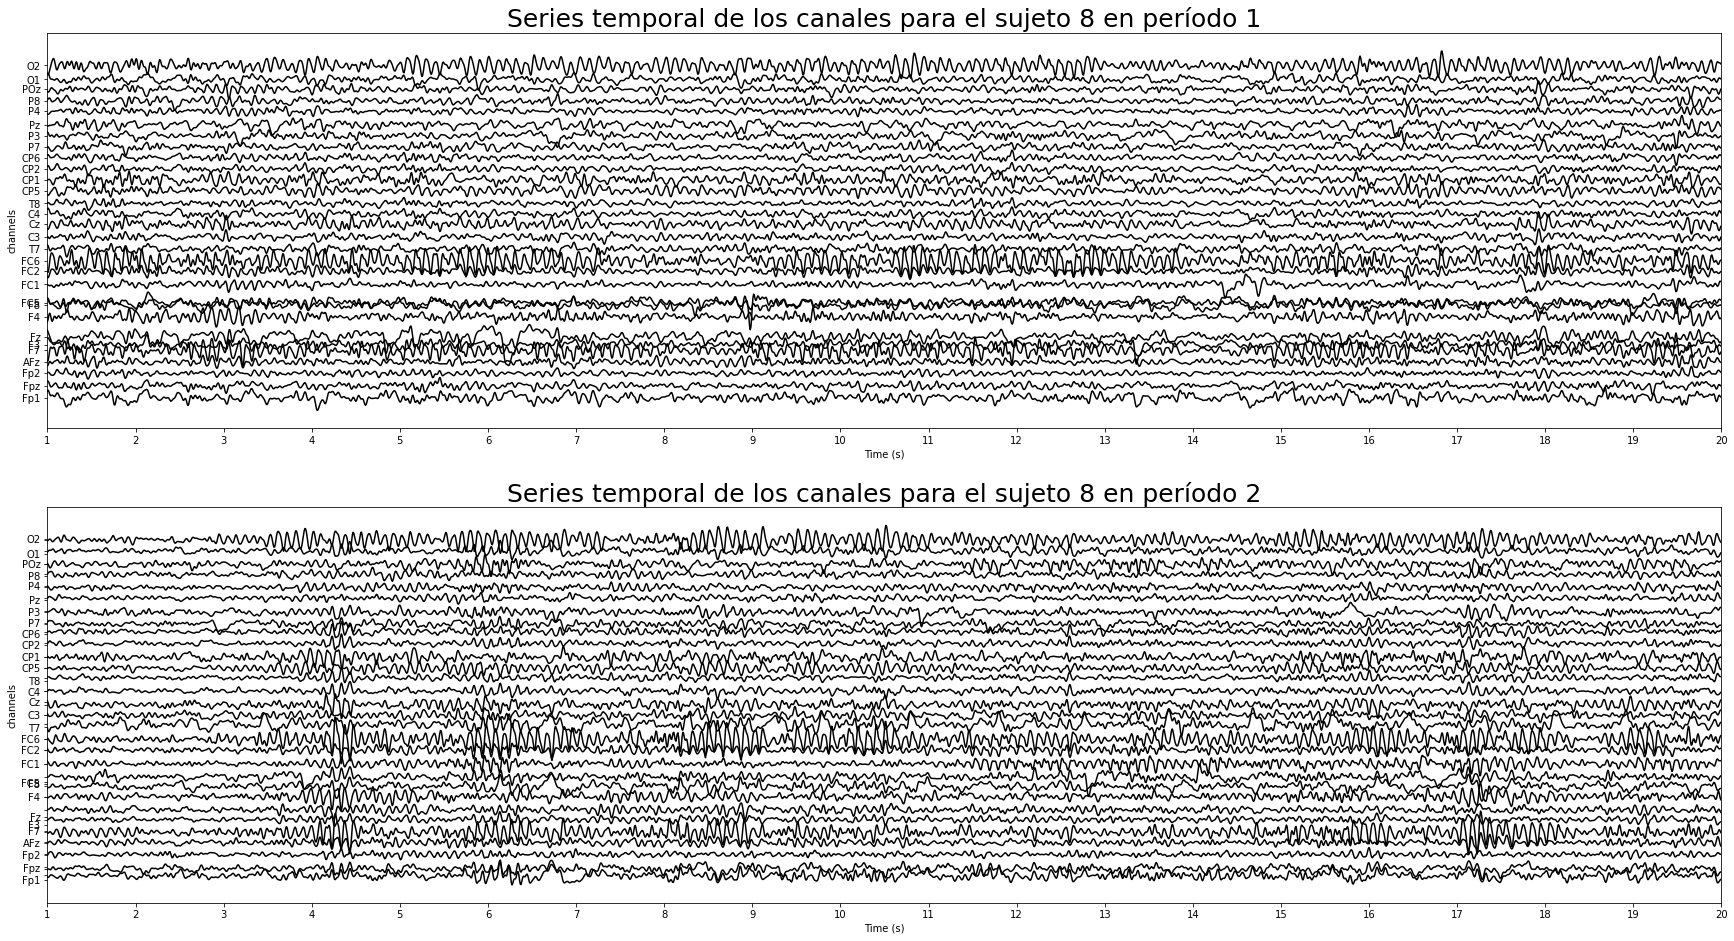

In [ ]:
# Levanto y grafico los txt crudos

inicio = 1
fin    = 20
xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
#fig.suptitle('Series temporales (uV)')
yticks=[]

# filename = '/suj_8_bl_1.txt'
sujetos = [8]#,9]#,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
alto_graf = cant_graf*8
fig, ax = plt.subplots(nrows=cant_graf, ncols=1,figsize=(30,alto_graf))

k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    
    # for k,ax in enumerate(axes.flatten()):
    for c in np.arange(ch):
        temp = EEGdata[c,inicio*srate:fin*srate]
        dmin=np.min(temp)
        dmax=np.max(temp)
        vmedio = np.mean([dmin,dmax])+30*c
        yticks.append(vmedio)
        ax[j-1+k].plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'k')
    ax[j-1+k].set_xlim([inicio*srate,fin*srate])
    ax[j-1+k].set_xticks(xticks)
    ax[j-1+k].set_xticklabels(np.arange(inicio,fin+1))
    ax[j-1+k].set_yticks(yticks)
    ax[j-1+k].set_yticklabels(mont1020_30.ch_names)
    ax[j-1+k].set_ylabel('channels')
    ax[j-1+k].set_xlabel('Time (s)')
    ax[j-1+k].set_title("Series temporal de los canales para el sujeto "+ f'{i}' +" en período "+f'{j}', fontsize=25)
    # plt.show()
    
    # k += 2  # porque cada sujeto tiene dos gráficos

plt.savefig( 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.png')
files.download('suj_'+f'{i}'+'_bl_'+f'{j}'+'.png') 


# Promedios de las topografías, por sujeto y por período

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

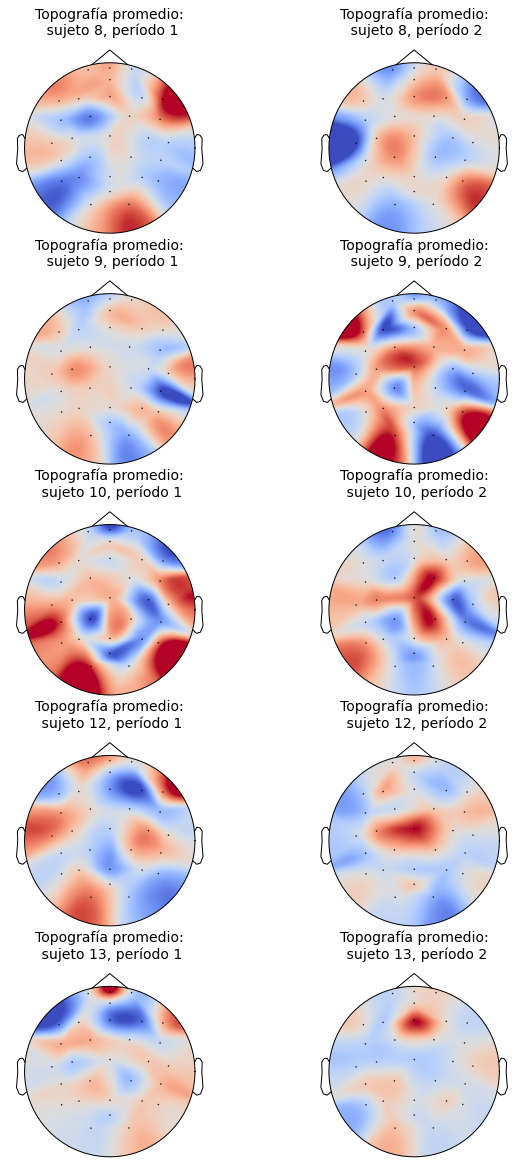

In [ ]:
# filename = '/suj_8_bl_1.txt'
sujetos = [8,9,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
# alto_graf = cant_graf*8
fig2, ax2 = plt.subplots(nrows=5, ncols=2, figsize=(10, 20), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

dic_toposProm ={}
k=0 #solamente para iterar por los axes
fila = 0
columna = 0

for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    
    EEGdata_meanTopografia = np.mean(EEGdata, axis=1)
    dic_toposProm['suj_'+f'{i}'+'_est_'+f'{j}'] = EEGdata_meanTopografia

    mne.viz.plot_topomap(EEGdata_meanTopografia,
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax2[fila, columna],show=False)
    ax2[fila, columna].set_title('Topografía promedio:\n sujeto '+f'{i}'+ ', período '+ f'{j}', size = 14)  
    columna +=1
  columna = 0
  fila +=1
  # k += 2  # porque cada sujeto tiene dos gráficos

plt.savefig( 'topografias_prom.png')
files.download('topografias_prom.png') 

# Distancias entre topografías promedio

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

metrics = ['euclidean', 'manhattan', 'cosine', 'correlation'] # hay otras. Ver links anteriores.
# Obs: como son topografías promedio, las distancias coseno y correlation dan igual.
metric = metrics[2]
print(metric)
for i in sujetos:
  print('suj_'+f'{i}'+'_dist_entre_periodos: ', pairwise_distances([dic_toposProm['suj_'+f'{i}'+'_est_1']],[dic_toposProm['suj_'+f'{i}'+'_est_2']], metric=metric))

cosine
suj_8_dist_entre_periodos:  [[1.21476584]]
suj_9_dist_entre_periodos:  [[0.4822301]]
suj_10_dist_entre_periodos:  [[0.5935793]]
suj_12_dist_entre_periodos:  [[0.84494105]]
suj_13_dist_entre_periodos:  [[1.33842016]]


## PCA Con datos concatenados según período. Pre vs Post.

In [ ]:
# PCA con datos concatenados a lo largo del tiempo, para todos los sujetos pre
# y todos los sujetos post.
 
# filename = '/suj_8_bl_1.txt'
sujetos = [8,9,10,12,13] # sujetos a graficar: 8,9,10,12,13
# periodos = [1] #hay solamente dos: 1, 2


all_subjects_pre = pd.DataFrame()
all_subjects_post = pd.DataFrame()
for i in sujetos:
  filename_pre = 'suj_'+f'{i}'+'_bl_'+'1'+'.txt'
  filename_post = 'suj_'+f'{i}'+'_bl_'+'2'+'.txt'
  datos_pre = pd.read_csv(path + filename_pre, sep = ',', header = None)
  datos_post = pd.read_csv(path + filename_post, sep = ',', header = None)
  all_subjects_pre = pd.concat([all_subjects_pre, datos_pre], axis = 1)# .to_numpy()
  all_subjects_post = pd.concat([all_subjects_post, datos_post], axis = 1)# .to_numpy()
  



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

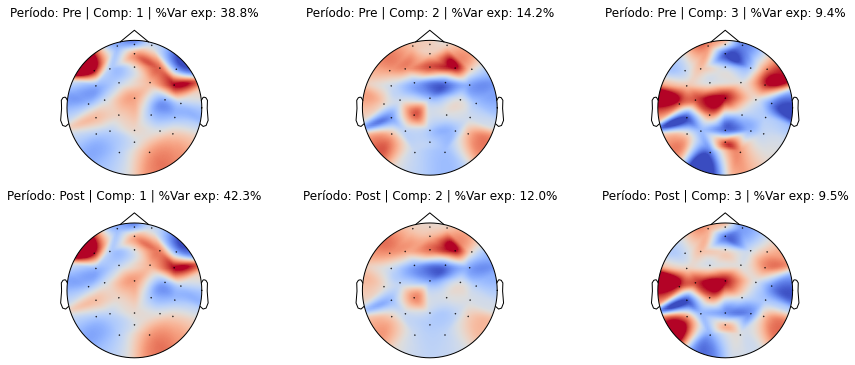

In [ ]:
cant_comp = 3

cant_graf = 2
alto_graf = cant_graf * 3
fig3, ax3 = plt.subplots(nrows=cant_graf, ncols=cant_comp, figsize=(15, alto_graf), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)


pca_pre = decomposition.PCA(n_components=cant_comp)
pca_post = decomposition.PCA(n_components=cant_comp)

pca_pre.fit(all_subjects_pre)
pcs_pre = pd.DataFrame(pca_pre.transform(all_subjects_pre))
var_pre = pd.DataFrame(pca_pre.explained_variance_ratio_)

pca_post.fit(all_subjects_post)
pcs_post = pd.DataFrame(pca_post.transform(all_subjects_post))
var_post = pd.DataFrame(pca_post.explained_variance_ratio_)

pcs = pd.concat([pcs_pre, pcs_post], axis = 1)
var = pd.concat([var_pre, var_post], axis = 0, ignore_index = True)
labels = {0: 'Pre', 3: 'Post'}
k = 0
for i in (0,3):
  for p in range(cant_comp):
    mne.viz.plot_topomap(pcs.iloc[:,p+i],
                         info_eeg,
                         cmap='coolwarm', contours=0,
                         axes=ax3[k,p],show=False)
    ax3[k,p].set_title('Período: ' + f'{labels[i]}' + ' | Comp: ' + f'{p+1}' + ' | %Var exp: ' + str(round(var.iloc[i+p,0]*100,1)) + '%')  
  k += 1

plt.savefig( 'pca_pre_y_post.png')
files.download('pca_pre_y_post.png') 

# Distancias para cada PC entre períodos

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

metrics = ['euclidean', 'manhattan', 'cosine', 'correlation'] # hay otras. Ver links anteriores.
# Obs: como son topografías promedio, las distancias coseno y correlation dan igual.
metric = metrics[3]
print(metric)
for p in range(cant_comp):
  print('PC'+f'{p+1}'+'_dist_entre_periodos ', pairwise_distances([pcs_pre.iloc[:,p]],[pcs_post.iloc[:,p]], metric=metric))

correlation
PC1_dist_entre_periodos  [[0.00270225]]
PC2_dist_entre_periodos  [[0.02503452]]
PC3_dist_entre_periodos  [[0.07077482]]


# Referenciar datos el promedio

In [26]:


# Datos referenciados a su promedio (de toda la señal en cada uno de los electrodos)


# filename = '/suj_8_bl_1.txt'
sujetos = [8,9,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

dic_datos_ref = {}

# k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    datos_mean = datos.mean(axis = 0)

    # datos_std = datos.std(axis = 1)
    datos_ref = datos.sub(datos_mean, axis = 1)#.divide(datos_std, axis = 0 ) # zscore comentado

    key_name = 'suj_'+f'{i}'+'_est_'+f'{j}'
    dic_datos_ref[key_name] = datos_ref
    # dic_datos_ref[key_name] = datos
    
    
# dic_datos_ref["suj_8_est_1"]



# GFP, picos, y guardar la señal en la posición de los picos

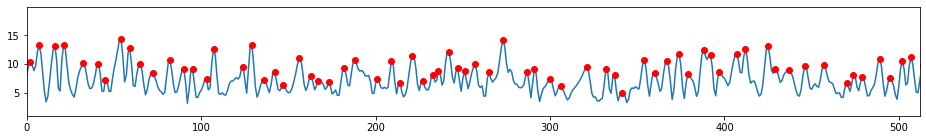

In [33]:
# Calculo GFP

dic_gfp = {}
for key in dic_datos_ref.keys():
    dic_gfp[key] = dic_datos_ref[key].std(ddof=0) #ddof=0 es para que divida por N (divide por N-ddof)
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.std.html




# busco picos de GFP y guardo GFP en las posiciones de los picos

# busco picos de GFP
from scipy.signal import find_peaks 

dic_gfp_posPicos = {}
for key in dic_gfp.keys():
  peaks_pos, peaks_value = find_peaks(dic_gfp[key], prominence=0.8)
  dic_gfp_posPicos[key] = peaks_pos


# Guardo GFP y señales en las posiciones de los picos
dic_datos_ref_enPicos = {}
dic_gfp_enPicos = {}
for key in dic_gfp_posPicos.keys():
  peaks_pos = dic_gfp_posPicos[key]
  dic_gfp_enPicos[key] = dic_gfp[key][peaks_pos]
  dic_datos_ref_enPicos[key] = dic_datos_ref[key].iloc[:,peaks_pos]


# Grafico una parte para ver cómo van quedando los picos
inicio = 0
fin = 4
fig,ax=plt.subplots(ncols=1,figsize=(16,2))

key = 'suj_8_est_1'
ax.plot(dic_gfp[key])
ax.set_xlim([inicio*srate,fin*srate])
# peaks_pos = 
ax.plot(dic_gfp_posPicos[key],dic_gfp_enPicos[key],'ro')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

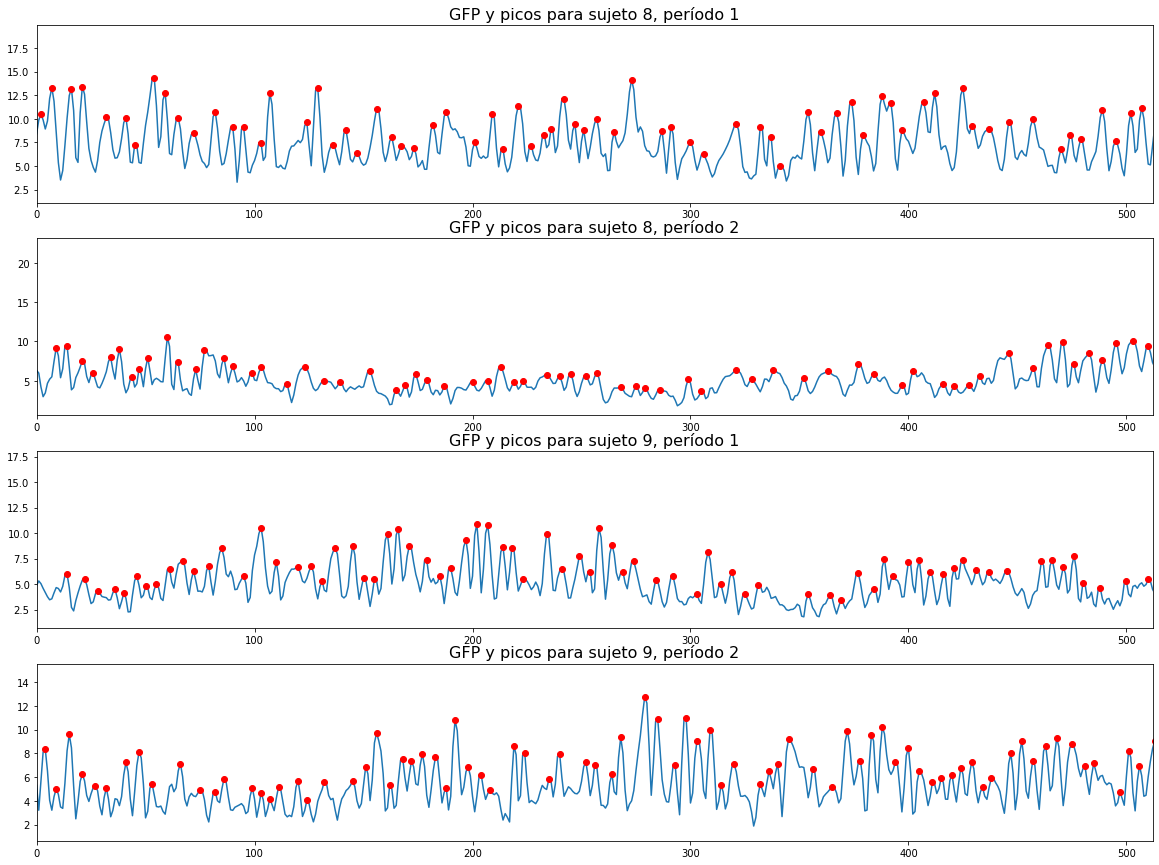

In [ ]:

sujetos = [8,9] #12,13,10] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

rows = len(sujetos)

fig4, ax4 = plt.subplots(nrows=rows*2, ncols=1, figsize=(20, 15) )#, gridspec_kw=dict(top=0.9), sharex=True, sharey=True)

k = 0
for i in sujetos:
  for j in periodos:
    key = 'suj_'+f'{i}'+'_est_'+f'{j}'

    ax4[k].plot(dic_gfp[key])
    ax4[k].set_xlim([inicio*srate,fin*srate])
    ax4[k].plot(dic_gfp_posPicos[key],dic_gfp_enPicos[key],'ro')
    ax4[k].set_title('GFP y picos para sujeto '+f'{i}'+ ', período '+ f'{j}', size = 16)

    k +=1

plt.savefig( 'gfp.png')
files.download('gfp.png') 